Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

115/115 [==============================] - 0s 4ms/step - loss: 0.7716 - mae: 0.5019 - mse: 0.7716 - val_loss: 0.3600 - val_mae: 0.3297 - val_mse: 0.3600
Epoch 2/100
115/115 [==============================] - 0s 3ms/step - loss: 0.3733 - mae: 0.3593 - mse: 0.3733 - val_loss: 0.2995 - val_mae: 0.2824 - val_mse: 0.2995
Epoch 3/100
115/115 [==============================] - 0s 3ms/step - loss: 0.2948 - mae: 0.3228 - mse: 0.2948 - val_loss: 0.4169 - val_mae: 0.3423 - val_mse: 0.4169
Epoch 4/100
1

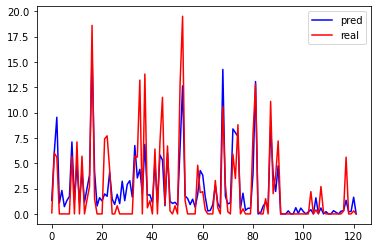

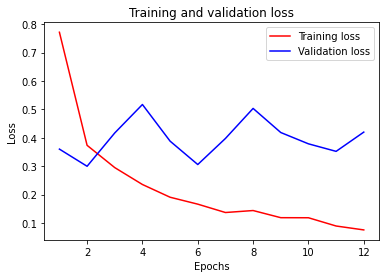

-0.02786957529135309


In [16]:
import os
import json
from read_data import Reader
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
tf.random.set_seed(2)

def make_dataset():
    """
    To make tf.data.Dataset for training and test_x, test_y for testing and evaluation.
    :return: train_dataset, val_dataset, test_features, test_labels
    """
    reader = Reader()
    with open("E:\\rainfall\\FullyConnectedPredRain\\wsl_evaluation\\model\\config.json", 'r') as json_file:
        config = json.load(json_file)

    features = config['features']
    train = reader.read_many('train', features)
    val = reader.read_many('val', features)
    test = reader.read_many('test', features)

    train_mean = train.mean(axis=0)['Label']
    train_std = train.std(axis=0)['Label']

    def normalization(dataframe):
        return (dataframe - train.mean(axis=0)) / train.std(axis=0)

    def dataframe_to_dataset(dataframe, shuffle=True, repeat=True, batch_size=16):
        dataframe = dataframe.copy()
        labels = dataframe.pop('Label')
        dataset = tf.data.Dataset.from_tensor_slices((dataframe, labels))
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(dataframe))
        dataset = dataset.batch(batch_size)
        if repeat:
            dataset = dataset.repeat()
        return dataset

    train, val, test = normalization(train), normalization(val), normalization(test)
    train_dataset = dataframe_to_dataset(train)
    val_dataset = dataframe_to_dataset(val, shuffle=False)
    test_labels = test.pop('Label')
    test_features = test
    return train_dataset, val_dataset, test_features, test_labels, train_mean, train_std


def dense_model_sequential_1():
    """
    To make a model in a sequential way (way 1).
    Performs exactly the same as the two methods below.
    :return: Model established
    """
    model = tf.keras.Sequential()
    model.add(layers.Dense(39, activation='sigmoid'))
    model.add(layers.Dense(120, activation='sigmoid'))
    model.add(layers.Dense(200, activation='sigmoid'))
    model.add(layers.Dense(1))

    optimizer = tf.keras.optimizers.Adam(
        learning_rate=0.01
    )
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])

    return model


if __name__ == '__main__':
    epochs = 100
    size_train, size_val = 927, 365 #2091, 713
    batch_size = 8 #32
    train_ds, val_ds, test_x, test_y, train_mean, train_std = make_dataset()
    model = dense_model_sequential_1()
    callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=10, verbose=0,
        mode='auto', baseline=None, restore_best_weights=True
    )
    history = model.fit(train_ds, epochs=epochs, steps_per_epoch=size_train // batch_size,
                        validation_data=val_ds, validation_steps=size_val // batch_size,
                        callbacks=[callback])
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    print(model.summary())

    pred_y = model.predict(test_x)
    pred_y1=pred_y
    pred_y = pred_y * train_std + train_mean
    test_y = test_y * train_std + train_mean

    for index in range(len(pred_y)):
        if pred_y[index]<0:
            pred_y[index]=0

    # paint pred and real
    x = range(122)
    plt.plot(x, pred_y, label="pred", color="b")
    plt.plot(x, test_y, label="real", color="r")
    plt.legend()
    plt.show()
    plt.close()

    #paint loss and accuracy
    history_dict = history.history
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    plt.close()

    #result
    print((test_y.mean()-pred_y.mean())/pred_y.mean())

In [7]:
from sklearn.metrics import r2_score
r_square = r2_score(y_true=test_y,y_pred=pred_y)
print("R-square is ",r_square)

R-square is  0.6587860311553849
